In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cu118
2.0.0


In [2]:
import io
import os
import tarfile
import tempfile

import boto3 #pip install boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)



100%|██████████| 7.99k/7.99k [00:00<00:00, 3.41MB/s]
100%|██████████| 106k/106k [00:00<00:00, 3.44MB/s]
100%|██████████| 53.2k/53.2k [00:00<00:00, 3.69MB/s]


In [3]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
# Where
#
# -  ``sample_rate`` is the sampling rate of the audio
# -  ``num_channels`` is the number of channels
# -  ``num_frames`` is the number of frames per channel
# -  ``bits_per_sample`` is bit depth
# -  ``encoding`` is the sample coding format
#
# ``encoding`` can take on one of the following values:
#
# -  ``"PCM_S"``: Signed integer linear PCM
# -  ``"PCM_U"``: Unsigned integer linear PCM
# -  ``"PCM_F"``: Floating point linear PCM
# -  ``"FLAC"``: Flac, `Free Lossless Audio
#    Codec <https://xiph.org/flac/>`__
# -  ``"ULAW"``: Mu-law,
#    [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
# -  ``"ALAW"``: A-law
#    [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
# -  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
# -  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
# -  ``"AMR_NB"``: Adaptive Multi-Rate
#    [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
# -  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
#    [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
# -  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
# -  ``"GSM"``: GSM-FR
#    [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
# -  ``"HTK"``: Single channel 16-bit PCM
# -  ``"UNKNOWN"`` None of above

In [4]:
metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


In [5]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(_hide_seek(response.raw))
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchaudio/backend/sox_io_backend.py:106: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)


In [6]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [7]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")


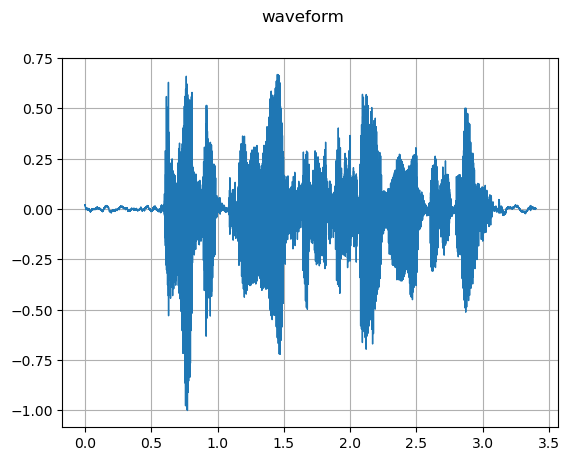

In [8]:
plot_waveform(waveform, sample_rate)

In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

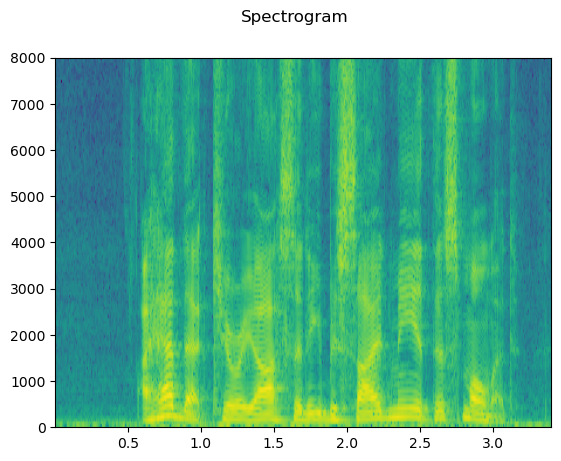

In [10]:
plot_specgram(waveform, sample_rate)

In [11]:
Audio(waveform.numpy()[0], rate=sample_rate)

/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchaudio/backend/sox_io_backend.py:235: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)


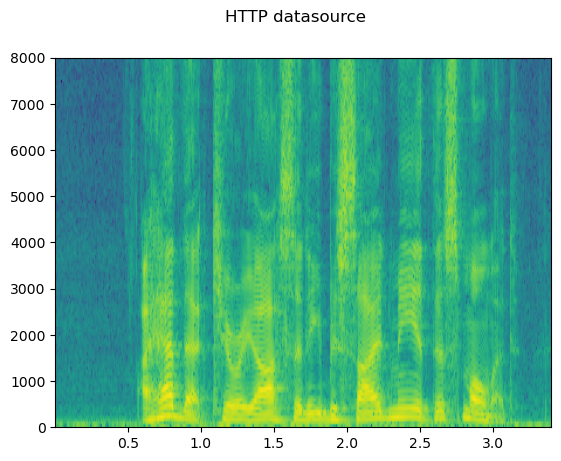

In [12]:
# Load audio data as HTTP request
url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with requests.get(url, stream=True) as response:
    waveform, sample_rate = torchaudio.load(_hide_seek(response.raw))
plot_specgram(waveform, sample_rate, title="HTTP datasource")


100%|██████████| 110k/110k [00:00<00:00, 893kB/s] 


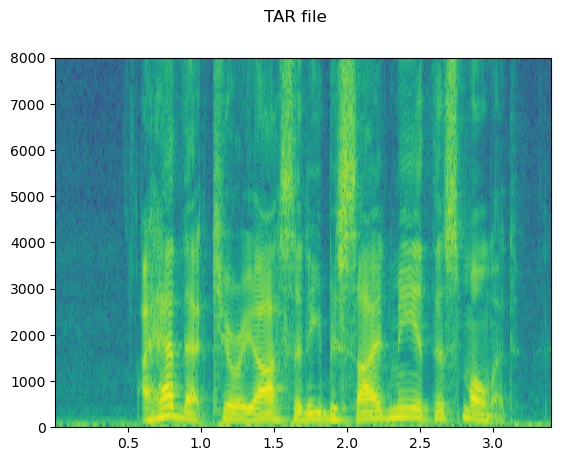

In [13]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(tar_path, mode="r") as tarfile_:
    fileobj = tarfile_.extractfile(tar_item)
    waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

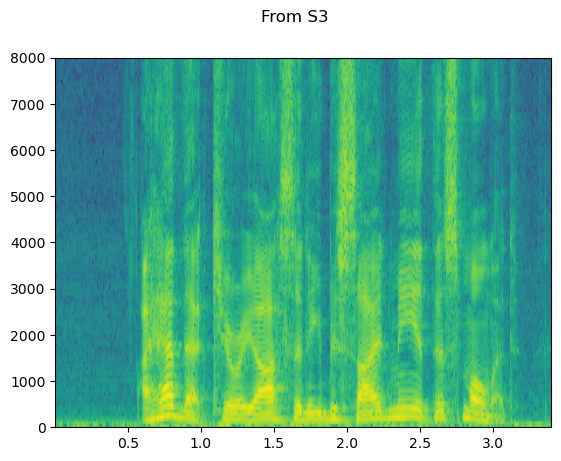

In [14]:
# Load audio from S3
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)
waveform, sample_rate = torchaudio.load(_hide_seek(response["Body"]))
plot_specgram(waveform, sample_rate, title="From S3")

In [15]:
# Providing ``num_frames`` and ``frame_offset`` arguments restricts
# decoding to the corresponding segment of the input.
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
print("Fetching all the data...")
with requests.get(url, stream=True) as response:
    waveform1, sample_rate1 = torchaudio.load(_hide_seek(response.raw))
    waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
    print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(url, stream=True) as response:
    waveform2, sample_rate2 = torchaudio.load(
        _hide_seek(response.raw), frame_offset=frame_offset, num_frames=num_frames
    )
    print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 65580 bytes
Checking the resulting waveform ... matched!


In [16]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

In [17]:
# Save without any encoding option.
# The function will pick up the encoding which
# the provided data fit
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /tmp/tmpd40idpmd/save_example_default.wav
----------
 - File size: 217658 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)



In [18]:
# Save as 16-bit signed integer Linear PCM
# The resulting file occupies half the storage but loses precision
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: /tmp/tmplvkw5ufd/save_example_PCM_S16.wav
----------
 - File size: 108844 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



In [19]:
formats = [
    "flac",
    # "vorbis",
    # "sph",
    # "amb",
    # "amr-nb",
    # "gsm",
]

######################################################################
#
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir:
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)


----------
Source: /tmp/tmpikxff92y/save_example.flac
----------
 - File size: 37141 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=24, encoding=FLAC)



In [20]:
# Saving to file-like object
# --------------------------
#
# Similar to the other I/O functions, you can save audio to file-like
# objects. When saving to a file-like object, argument ``format`` is
# required.
#


waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF2R\x03\x00WAVEfmt '


/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/torchaudio/backend/sox_io_backend.py:416: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)


REF: https://github.com/pytorch/audio/blob/main/examples/tutorials/audio_io_tutorial.py

https://pytorch.org/audio/0.11.0/tutorials/audio_io_tutorial.html